In [49]:
import numpy as np
import os
from batter.input_process import get_configure_from_file
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['JAX_PLATFORMS'] = 'cpu'
import pandas as pd
from alchemlyb.estimators import MBAR

In [38]:
sim_config = get_configure_from_file('./mor-msdr-rep2.in')
work_dir = 'MOR_SC103_apo/v1/rep3/'
work_dir = 'MOR_SC103_Gi/v1/rep2/'
work_dir = '7T2G_MP_apo/v1/rep1/'

03-Dec-2024 08:13:07 | INFO | Converting lipid input: ['POPC']
03-Dec-2024 08:13:07 | INFO | New lipid_mol list: ['POPC', 'PA', 'PC', 'OL']


In [39]:
lambdas = sim_config.lambdas

comp = 'e'
comp = 'v'
K = len(lambdas)

rest_files = [
    f'{work_dir}/fe/pose0/sdr/{comp}{i:02d}/energies.dat' for i in range(K)
]
# check if all files exist
for f in rest_files:
    if not os.path.exists(f):
        raise FileNotFoundError(f)

In [40]:
temperature = 310.0  # K
kB = 1.381e-23 * 6.022e23 / (4.184 * 1000.0)  # Boltzmann constant in kJ/mol/K
beta = 1/(kB * temperature)  # beta
R = 0
mode = 'all'
N_max = 20000  # Max frames for any simulation window, you should check this if you did some long runs


In [41]:
# Allocate storage for simulation data
# N_k[k] is the number of snapshots to be used from umbrella simulation k
N = np.zeros([K], np.int32)
Neff = np.zeros([K], np.int32)
Nind = np.zeros([K], np.int32)
val = np.zeros([N_max, K, K], np.float64)           # value of the restrained variable at each frame n
g = np.zeros([K], np.float64)
u = np.zeros([N_max], np.float64)

# Calculate Statistical Inefficiency (g)
def calcg(data):
    sum = 0
    randnum = ("%05.0f" % (int(100000*np.random.random())))
    datafn = '/dev/shm/series.'+randnum+'.dat'
    acffn = '/dev/shm/acf.'+randnum+'.dat'
    cppfn = '/dev/shm/pt-acf.'+randnum+'.in'
    np.savetxt(datafn, data)
    cpptin = open(cppfn, 'w')
    cpptin.write("readdata "+datafn+" name "+randnum+"\nautocorr "+randnum+" out "+acffn+" noheader\n")
    cpptin.close()

    FNULL = open(os.devnull, 'w')
    run_with_log(f'{cpptraj} -i {cppfn}')

    with open(acffn, 'r') as acf:
        for line in acf:
            col = line.split()
            t = float(col[0]) - 1.0
    T = t

    with open(acffn, 'r') as acf:
        for line in acf:
            col = line.split()
            t = float(col[0]) - 1.0
            v = float(col[1])
            if t == 0:
                continue
            if v < 0.0:
                break
            sum += (1 - (t/T))*(v)

    run_with_log(f'rm {datafn} {acffn} {cppfn}')

    return 1+(2*sum)

for k in range(K):
    # Read in Values for restrained variables for each simulation
    filename = rest_files[k]
    infile = open(filename, 'r')
    restdat = infile.readlines()     # slice off first 20 lines  readlines()[20:]
    infile.close()
    # Parse Data
    n = 0
    lambdas = []
    for line in restdat:
        cols = line.split()
        if len(cols) >= 1:
            lambdas.append(float(cols[1]))
        if len(cols) == 0:
            break
    for line in restdat:
        cols = line.split()
        if len(cols) >= 1:
            if '**' not in cols[2]:
                lamb = float(cols[1].strip())
                val[n, k, lambdas.index(lamb)] = cols[2]
        if len(cols) == 0:
            n += 1
    N[k] = n

    # Calculate reduced potential
    u[0:N[k]] = beta*(val[0:N[k], k, k])

    # Subsample or not
    if mode == 'sub':
        g[k] = calcg(u[0:N[k]])
        subs = timeseries.subsampleCorrelatedData(np.zeros([N[k]]), g=g[k])
        Nind[k] = len(subs)
        Neff[k] = Nind[k]
    else:
        g[k] = 1.00
        Neff[k] = N[k]

    print("Processed Window %5.0f.  N= %12.0f.  g= %10.3f   Neff= %12.0f" % (k, N[k], g[k], Neff[k]))

# Calculate decoupling energy
Upot = np.zeros([K, K, np.max(Neff)], np.float64)
for k in range(K):
    for l in range(K):
        Upot[k, l, 0:Neff[k]] = beta*(val[0:Neff[k], k, l])

val = []

Processed Window     0.  N=          600.  g=      1.000   Neff=          600
Processed Window     1.  N=          600.  g=      1.000   Neff=          600
Processed Window     2.  N=          600.  g=      1.000   Neff=          600
Processed Window     3.  N=          600.  g=      1.000   Neff=          600
Processed Window     4.  N=          600.  g=      1.000   Neff=          600
Processed Window     5.  N=          600.  g=      1.000   Neff=          600
Processed Window     6.  N=          600.  g=      1.000   Neff=          600
Processed Window     7.  N=          600.  g=      1.000   Neff=          600
Processed Window     8.  N=          600.  g=      1.000   Neff=          600
Processed Window     9.  N=          600.  g=      1.000   Neff=          600
Processed Window    10.  N=          600.  g=      1.000   Neff=          600
Processed Window    11.  N=          600.  g=      1.000   Neff=          600
Processed Window    12.  N=          600.  g=      1.000   Neff=

In [42]:
u_df = pd.DataFrame(columns=['time', 'fep-lambda'] + list(lambdas))

In [43]:
data_frames = []

for i, u_pot_lambda in enumerate(Upot):
    fep = u_pot_lambda.T  # Transpose if needed
    time = np.arange(fep.shape[0])  # Create the time array based on the number of rows in `fep`
    fep_lambda = np.ones(fep.shape[0]) * lambdas[i]  # Create the fep-lambda array based on the current lambda
    # Stack the arrays horizontally
    result = np.hstack([time[:, None], fep_lambda[:, None], fep])  
    
    df = pd.DataFrame(result,
                      columns=['time', 'fep-lambda'] + list(lambdas))
    data_frames.append(df)

# Combine all DataFrames into a single DataFrame
u_df = pd.concat(data_frames, ignore_index=True)
# set index to time and fep-lambda
u_df.set_index(['time', 'fep-lambda'], inplace=True)

In [44]:
mbar_coul = MBAR()
mbar_coul.fit(u_df)

MBAR()

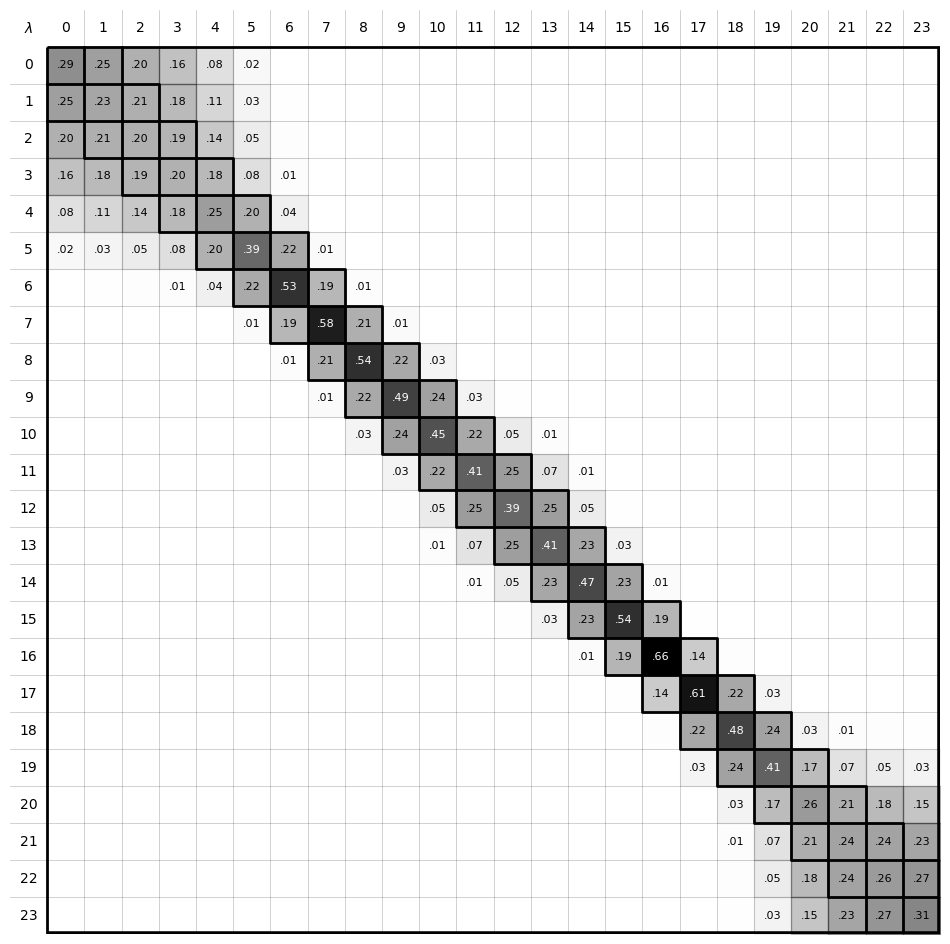

In [45]:
from alchemlyb.visualisation import plot_mbar_overlap_matrix
ax = plot_mbar_overlap_matrix(mbar_coul.overlap_matrix)

In [46]:
mbar_coul.delta_f_

,0.0001,0.0200,0.0400,0.0600,0.1000,0.1500,0.2000,0.2500,0.3000,0.3500,...,0.6000,0.6500,0.7000,0.7500,0.8000,0.8500,0.9200,0.9600,0.9800,0.9999
0.0001,0.000000,1.281315,2.826770,4.641624,9.103240,16.127593,24.092530,31.404953,37.078207,41.225625,...,49.811628,49.499205,47.302556,42.344462,35.852502,30.021892,24.311536,22.612266,22.173963,21.991783
0.0200,-1.281315,0.000000,1.545455,3.360309,7.821925,14.846278,22.811215,30.123638,35.796892,39.944310,...,48.530313,48.217890,46.021241,41.063147,34.571187,28.740577,23.030221,21.330951,20.892648,20.710469
0.0400,-2.826770,-1.545455,0.000000,1.814854,6.276470,13.300823,21.265760,28.578183,34.251437,38.398855,...,46.984858,46.672435,44.475786,39.517692,33.025732,27.195122,21.484766,19.785496,19.347193,19.165013
0.0600,-4.641624,-3.360309,-1.814854,0.000000,4.461616,11.485969,19.450906,26.763329,32.436583,36.584001,...,45.170004,44.857581,42.660932,37.702838,31.210878,25.380268,19.669912,17.970642,17.532339,17.350159
0.1000,-9.103240,-7.821925,-6.276470,-4.461616,0.000000,7.024352,14.989289,22.301712,27.974966,32.122385,...,40.708388,40.395965,38.199316,33.241221,26.749261,20.918652,15.208295,13.509026,13.070723,12.888543
0.1500,-16.127593,-14.846278,-13.300823,-11.485969,-7.024352,0.000000,7.964937,15.277360,20.950614,25.098032,...,33.684035,33.371613,31.174963,26.216869,19.724909,13.894299,8.183943,6.484674,6.046371,5.864191
0.2000,-24.092530,-22.811215,-21.265760,-19.450906,-14.989289,-7.964937,0.000000,7.312423,12.985677,17.133095,...,25.719098,25.406676,23.210026,18.251932,11.759972,5.929362,0.219006,-1.480263,-1.918566,-2.100746
0.2500,-31.404953,-30.123638,-28.578183,-26.763329,-22.301712,-15.277360,-7.312423,0.000000,5.673254,9.820672,...,18.406675,18.094253,15.897603,10.939509,4.447549,-1.383061,-7.093417,-8.792686,-9.230989,-9.413169
0.3000,-37.078207,-35.796892,-34.251437,-32.436583,-27.974966,-20.950614,-12.985677,-5.673254,0.000000,4.147418,...,12.733421,12.420999,10.224349,5.266255,-1.225705,-7.056315,-12.766671,-14.465941,-14.904243,-15.086423
0.3500,-41.225625,-39.944310,-38.398855,-36.584001,-32.122385,-25.098032,-17.133095,-9.820672,-4.147418,0.000000,...,8.586003,8.273580,6.076931,1.118837,-5.373123,-11.203733,-16.914089,-18.613359,-19.051662,-19.233842


In [47]:
energy_kcal = mbar_coul.delta_f_.values[0, -1] * 0.5922 / 298 * 310
print(f'Free energy difference: {energy_kcal:.2f} kcal/mol')

Free energy difference: 13.55 kcal/mol


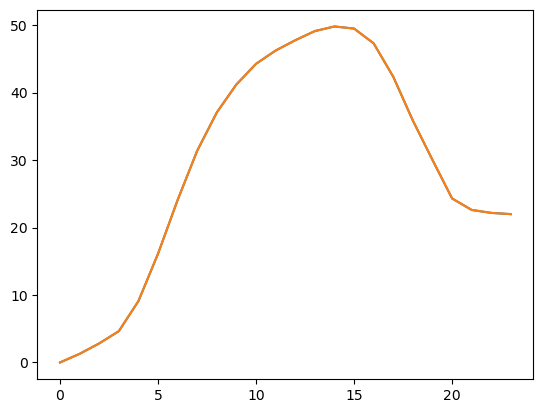

In [48]:
import matplotlib.pyplot as plt
plt.plot(mbar_coul.delta_f_.values[0, :])
plt.plot(-mbar_coul.delta_f_.values[:, 0])